# Classification


In [1]:
# Data Manipulation
import pandas as pd 
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Data-Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Random Forests
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (
    precision_score,
    recall_score,
    fbeta_score
)
from xgboost import plot_importance
import shap

## Reading Data

In [2]:
train = pd.read_csv('../data/classification_data/classification_train.csv')
print(train.shape)
train.head()

(670, 3)


,x1,x2,target
0,1.934224,-0.111822,1
1,1.767383,-0.976402,1
2,0.937101,-0.085633,1
3,1.340732,0.166960,1
4,-0.199901,-0.155204,1


In [3]:
test = pd.read_csv('../data/classification_data/classification_test.csv')
print(test.shape)
test.head()

(330, 3)


,x1,x2,target
0,1.114204,-0.434321,1
1,-1.238490,0.521390,0
2,-0.091781,-0.169471,1
3,0.298820,0.076368,0
4,-0.265779,0.479812,1


## EDA

<AxesSubplot:xlabel='x1', ylabel='x2'>

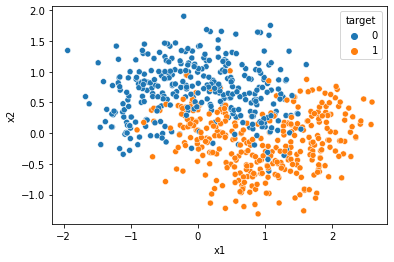

In [4]:
sns.scatterplot(data=train, x="x1", y="x2", hue="target")

Podemos ver o caráter não-linear dos dados. Um função linear de x1 e x2, por exemplo: y = a \* x1 + b \* x2, perderia muito o caráter não linear e classificaríamos muitos do grupo 1 como grupo 0 e vice-versa.

Procuramos alguma técnica que possa preservar essa caráter não-linear e também seja o mais simples possível para seguirmos o conceito de passimônia, ou seja, valorizarmos simplicada para facilitar a interpretação.

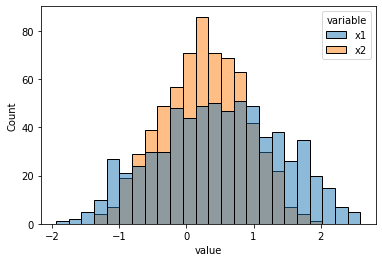

In [5]:
def plot_histogram(train):
    train = train.copy()
    train['Index'] = np.arange(len(train))
    train = pd.melt(train, id_vars=['Index'], value_vars=['x1', 'x2'])
    sns.histplot(train,
                x="value", hue="variable")

plot_histogram(train)

Como as duas variáveis estão na mesma escala, não há necessidade de pre-processar elas, normalizando elas, por exemplo. Não haveria viéis de escala neste caso nos modelos que usaremos.

<AxesSubplot:xlabel='target', ylabel='Count'>

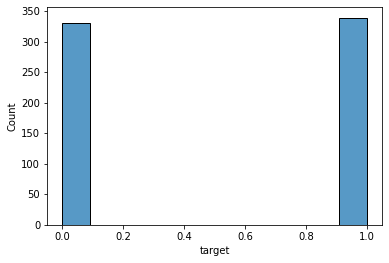

In [6]:
sns.histplot(data=train, x='target')

Os dados se encontram balanceados. Não precisaremos introduzir amostragem estratistificada para tentar mitigar o efeito que este problema traria, ou colocar pesos diferentes para as variáveis no modelo.

## Modelling

### Random Forest - Xgboost

In [7]:
X_train = train[['x1', 'x2']].values.copy()
y_train = train['target'].values.copy()
X_test = test[['x1', 'x2']].values.copy()
y_test = test['target'].values.copy()


seed = 25 + 7 + 2007 # beginning of the "Oncase" company.

rand_forests = XGBClassifier(
    colsample_bynode=0.8,
    learning_rate=1,
    max_depth= 5,
    num_parallel_tree= 50,
    objective= 'binary:logistic',
    subsample= 0.8,
    eval_metric='logloss',
    random_state= seed,
    use_label_encoder= False
)

rand_forests.fit(X_train, y_train)
y_pred = rand_forests.predict(X_test)
predictions = [round(value) for value in y_pred]

### Metrics

In [8]:
def metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    print("Precision: %.2f%%" % (precision * 100.0))

    recall = recall_score(y_true, y_pred)
    print("Recall: %.2f%%" % (recall * 100.0))

    # Fbeta = ((1 + beta^2) * Precision * Recall) / (beta^2 * Precision + Recall)
    f2_score = fbeta_score(y_true, y_pred, beta=2)
    print("F2-Score: %.2f%%" % (f2_score * 100.0))

In [9]:
metrics(y_test, predictions)

Precision: 86.25%
Recall: 85.71%
F2-Score: 85.82%


### Feature Importance


#### Analisando "Gains" e "Weights" para cada variável.

Entendendo a estimação dos parâmetros nos ajuda a entender os impactos de cada feature no output.

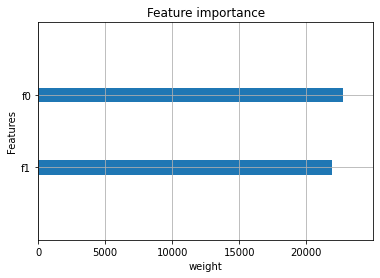

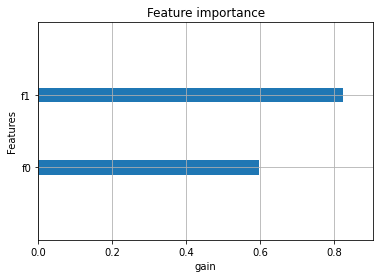

In [10]:
for importance_type in ["weight", "gain"]:
    plot_importance(rand_forests, 
                    importance_type=importance_type,
                    show_values=False,
                    xlabel=importance_type)

Consideremos f0 como 'x1' e f1 como 'x2'. Vemos no primeiro gráfico o número de vezes que a variável foi utilizada na árvore, ou seja, o quanto ela foi utilizada para fazer as divisões das suas folhas. Vemos que x1 foi mais usado, porém x2 não ficou muito atrás.

Já no segundo gráfico, podemos ver o ganho médio ao dividir a arvóre utilizando aquela variável específica, ou seja, o quanto ganhamos de precisão em estimar a probabilidade de pertencer a cada classe. Neste vemos uma disparidade entre x2 e x1. A variável x2 foi considerávelmente mais importante para criarmos a nossa arvóre do que x1.

#### SHAP Values

Os valores SHAP sõa criados utilizando Teoria dos Jogos para se medir o impacto local de cada valor predito em relação as features do nosso modelo. Resumidamente, em nosso modelo de duas features apenas, a interpretação que daremos é de que valores altos positivos de SHAP significam que aquela variável impactou na predição do output como 0, e valores baixos negativos significam que a variável impactou na predição do output como 1.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


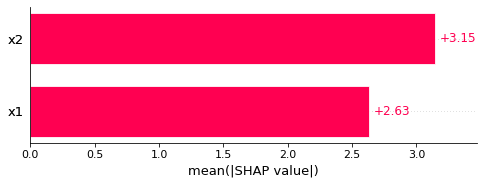

In [11]:
explainer = shap.Explainer(rand_forests)
shap_values = explainer(test[['x1', 'x2']])

shap.plots.bar(shap_values)

Vemos que a variável que mais impactou os valores do modelo é x2. A variável x2 é mais relevante para a classificação, em geral.

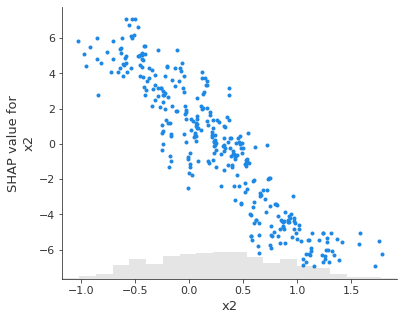

In [12]:
shap.plots.scatter(shap_values[:,'x2'])

Analisando agora com mais detalhes a x2 temos alguns insights de interesse. Vemos que conforme o valor de x2 diminui o impacto disto na variável "target" é de ter uma contribuição forte em classificar ela como 0, e conforme x2 aumenta, tendemos a classificar ela como 1. Uma relação bastante linear.

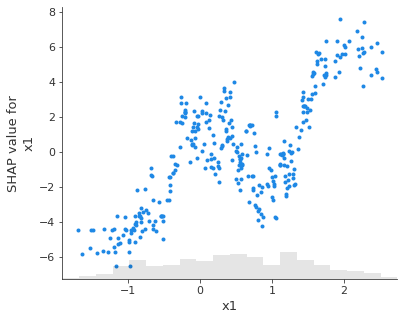

In [13]:
shap.plots.scatter(shap_values[:,'x1'])

Já na variável x1 não temos essa linearidade toda. Temos um comportamento bem mais não-linear. 

Se x1 é extramente negativa, o impacto de x1 sobre "target" é de puxar ela para 0, e se x1 é extramamente posivito, o impacto dela é para fazer com que a variável target seja 1.

Olhando com mais cuidado, vemos que as regiões onde x1 é perto de 0, o impacto de x1 foi de classificar target como 0, e na região onde x1 é mais perto de 1, vemos que o impacto foi de classificar target como 1.